<a href="https://colab.research.google.com/github/1kaiser/jax-unet/blob/master/SegmenatationJaxUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pathlib
urls = 'https://github.com/1kaiser/Media-Segment-Depth-MLP/releases/download/v0.2/s.zip'
data_dir = tf.keras.utils.get_file(origin=urls,
                                   fname='s',
                                   cache_subdir='/content/',
                                   archive_format='auto',
                                   untar=False,
                                   extract=True)
data_dir = pathlib.Path(data_dir)

821864248/821864248 [==============================] - 13s 0us/step


In [2]:
import glob, os
import tensorflow as tf
import numpy as np

PATH = '/content/'
BATCH_SIZE = 12
IMAGE_SIZE = 256


def read_train_data():
    x_files = [f for f in glob.glob(PATH + "MEDIAPIPEinput/*.png", recursive=True)]
    y_files = [f for f in glob.glob(PATH + "annotated_images/*.png", recursive=True)]

    def read_image(x_filename, y_filename):
        x_image_string = tf.io.read_file(x_filename)
        y_image_string = tf.io.read_file(y_filename)

        x_image_decoded = tf.image.decode_png(x_image_string, channels=3)
        y_image_decoded = tf.image.decode_png(y_image_string, channels=1)

        x_image_resized = tf.image.resize(x_image_decoded, [IMAGE_SIZE, IMAGE_SIZE])
        y_image_resized = tf.image.resize(y_image_decoded, [IMAGE_SIZE, IMAGE_SIZE])

        x_image_norm = x_image_resized / 255
        y_image_norm = y_image_resized / 255

        return x_image_norm, y_image_norm

    dataset = tf.data.Dataset.from_tensor_slices((x_files, y_files))

    dataset = dataset.map(read_image).shuffle(1000).batch(BATCH_SIZE)

    return dataset



In [3]:
!wget https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg -O a.png


def read_predict_data():
    file_path = '/content/a.png'
    image = tf.io.read_file(file_path)
    image_decoded = tf.image.decode_png(image, channels=3)
    image_resized = tf.image.resize(image_decoded, [IMAGE_SIZE, IMAGE_SIZE])
    image_norm = image_resized / 255

    return image_norm


def save_image(image):
    file_path = '/content/a.png'
    image = image * 255

    encode_image = tf.image.encode_png(image, format='png', quality=100)

    with open(file_path, 'wb') as fd:
        fd.write(encode_image)

--2023-01-08 22:16:29--  https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 18.64.173.84, 2600:9000:2342:fe00:0:5a51:64c9:c681, 2600:9000:2342:c000:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|18.64.173.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘a.png’

a.png                   [ <=>                ] 230.86K  --.-KB/s    in 0.06s   

2023-01-08 22:16:29 (3.90 MB/s) - ‘a.png’ saved [236398]



##**model**

![image1](https://user-images.githubusercontent.com/26379748/210260097-da2793f0-5e2d-4748-9445-f3f6757ef6f8.png)


In [4]:

import jax
from jax import numpy as jnp

!python -m pip install -q -U flax

import flax
from flax import linen as fnn


class Encoder(fnn.Module):
    features: int = 64
    training: bool = True

    @fnn.compact
    def __call__(self, x):
        z1 = fnn.Conv(self.features, kernel_size=(3, 3))(x)
        z1 = fnn.relu(z1)
        z1 = fnn.Conv(self.features, kernel_size=(3, 3))(z1)
        z1 = fnn.BatchNorm(use_running_average=not self.training)(z1)
        z1 = fnn.relu(z1)
        z1_pool = fnn.max_pool(z1, window_shape=(2, 2), strides=(2, 2))

        z2 = fnn.Conv(self.features * 2, kernel_size=(3, 3))(z1_pool)
        z2 = fnn.relu(z2)
        z2 = fnn.Conv(self.features * 2, kernel_size=(3, 3))(z2)
        z2 = fnn.BatchNorm(use_running_average=not self.training)(z2)
        z2 = fnn.relu(z2)
        z2_pool = fnn.max_pool(z2, window_shape=(2, 2), strides=(2, 2))

        z3 = fnn.Conv(self.features * 4, kernel_size=(3, 3))(z2_pool)
        z3 = fnn.relu(z3)
        z3 = fnn.Conv(self.features * 4, kernel_size=(3, 3))(z3)
        z3 = fnn.BatchNorm(use_running_average=not self.training)(z3)
        z3 = fnn.relu(z3)
        z3_pool = fnn.max_pool(z3, window_shape=(2, 2), strides=(2, 2))

        z4 = fnn.Conv(self.features * 8, kernel_size=(3, 3))(z3_pool)
        z4 = fnn.relu(z4)
        z4 = fnn.Conv(self.features * 8, kernel_size=(3, 3))(z4)
        z4 = fnn.BatchNorm(use_running_average=not self.training)(z4)
        z4 = fnn.relu(z4)
        z4_dropout = fnn.Dropout(0.5, deterministic=False)(z4)
        z4_pool = fnn.max_pool(z4_dropout, window_shape=(2, 2), strides=(2, 2))

        z5 = fnn.Conv(self.features * 16, kernel_size=(3, 3))(z4_pool)
        z5 = fnn.relu(z5)
        z5 = fnn.Conv(self.features * 16, kernel_size=(3, 3))(z5)
        z5 = fnn.BatchNorm(use_running_average=not self.training)(z5)
        z5 = fnn.relu(z5)
        z5_dropout = fnn.Dropout(0.5, deterministic=False)(z5)

        return z1, z2, z3, z4_dropout, z5_dropout


class Decoder(fnn.Module):
    features: int = 64
    training: bool = True

    @fnn.compact
    def __call__(self, z1, z2, z3, z4_dropout, z5_dropout):
        z6_up = jax.image.resize(z5_dropout, shape=(z5_dropout.shape[0], z5_dropout.shape[1] * 2, z5_dropout.shape[2] * 2, z5_dropout.shape[3]), method='nearest')
        z6 = fnn.Conv(self.features * 8, kernel_size=(2, 2))(z6_up)
        z6 = fnn.relu(z6)
        z6 = jnp.concatenate([z4_dropout, z6], axis=3)
        z6 = fnn.Conv(self.features * 8, kernel_size=(3, 3))(z6)
        z6 = fnn.relu(z6)
        z6 = fnn.Conv(self.features * 8, kernel_size=(3, 3))(z6)
        z6 = fnn.BatchNorm(use_running_average=not self.training)(z6)
        z6 = fnn.relu(z6)

        z7_up = jax.image.resize(z6, shape=(z6.shape[0], z6.shape[1] * 2, z6.shape[2] * 2, z6.shape[3]), method='nearest')
        z7 = fnn.Conv(self.features * 4, kernel_size=(2, 2))(z7_up)
        z7 = fnn.relu(z7)
        z7 = jnp.concatenate([z3, z7], axis=3)
        z7 = fnn.Conv(self.features * 4, kernel_size=(3, 3))(z7)
        z7 = fnn.relu(z7)
        z7 = fnn.Conv(self.features * 4, kernel_size=(3, 3))(z7)
        z7 = fnn.BatchNorm(use_running_average=not self.training)(z7)
        z7 = fnn.relu(z7)

        z8_up = jax.image.resize(z7, shape=(z7.shape[0], z7.shape[1] * 2, z7.shape[2] * 2, z7.shape[3]), method='nearest')
        z8 = fnn.Conv(self.features * 2, kernel_size=(2, 2))(z8_up)
        z8 = fnn.relu(z8)
        z8 = jnp.concatenate([z2, z8], axis=3)
        z8 = fnn.Conv(self.features * 2, kernel_size=(3, 3))(z8)
        z8 = fnn.relu(z8)
        z8 = fnn.Conv(self.features * 2, kernel_size=(3, 3))(z8)
        z8 = fnn.BatchNorm(use_running_average=not self.training)(z8)
        z8 = fnn.relu(z8)

        z9_up = jax.image.resize(z8, shape=(z8.shape[0], z8.shape[1] * 2, z8.shape[2] * 2, z8.shape[3]), method='nearest')
        z9 = fnn.Conv(self.features, kernel_size=(2, 2))(z9_up)
        z9 = fnn.relu(z9)
        z9 = jnp.concatenate([z1, z9], axis=3)
        z9 = fnn.Conv(self.features, kernel_size=(3, 3))(z9)
        z9 = fnn.relu(z9)
        z9 = fnn.Conv(self.features, kernel_size=(3, 3))(z9)
        z9 = fnn.BatchNorm(use_running_average=not self.training)(z9)
        z9 = fnn.relu(z9)

        y = fnn.Conv(1, kernel_size=(1, 1))(z9)
        y = fnn.sigmoid(y)

        return y


class UNet(fnn.Module):
    features: int = 64
    training: bool = True

    @fnn.compact
    def __call__(self, x):
        z1, z2, z3, z4_dropout, z5_dropout = Encoder(self.training)(x)
        y = Decoder(self.training)(z1, z2, z3, z4_dropout, z5_dropout)

        return y


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 9.9 MB/s eta 0:00:00


**unet visualization**

In [32]:
# def VisualizeKernel(state_parameters, epochs):
#   import cv2
#   from google.colab.patches import cv2_imshow
#   import numpy as np
#   params = state_parameters
#   a = []
#   kernel = params['kernel']
#   a.append(np.array(kernel))

#   import numpy as np
#   import matplotlib.pyplot as plt

#   rangex = len(params.keys())

#   fig, axs = plt.subplots(2, int(rangex/2)+1, figsize=(20,20))
#   images = params['kernel']
#   for i, ax in enumerate(axs.flatten()):
#       if i < len(images):
#           ax.imshow(images[i], cmap='ocean')
#       else:
#           ax.remove()
#   plt.savefig(str(epochs)+'.png', dpi=500)
#   plt.show()


##**run**

  0%|          | 0/20 [00:00<?, ?it/s]

frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dict_keys(['Decoder_0', 'Encoder_0'])
frozen_dic

  0%|          | 0/20 [00:26<?, ?it/s]

frozen_dict_keys(['Decoder_0', 'Encoder_0'])


TypeError: ignored

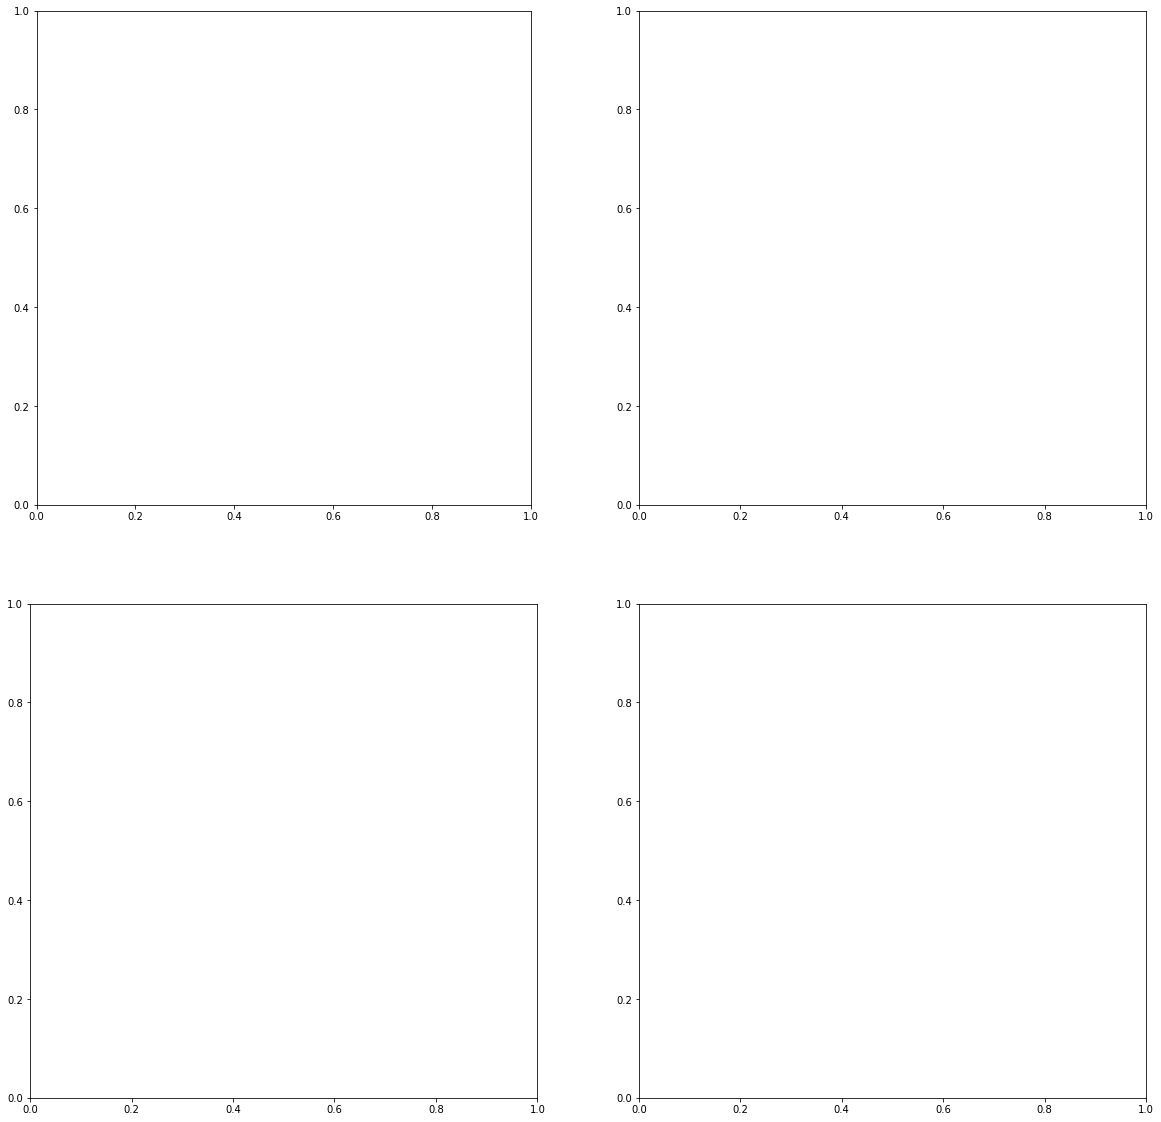

In [33]:
import time
from functools import partial

import jax
import optax

from jax import numpy as jnp
from flax.training.train_state import TrainState
from flax.training import checkpoints

from tqdm import tqdm

# from models import UNet
# from data import read_train_data, read_predict_data, save_image

CKPT_DIR = 'ckpts'
IMAGE_SIZE = 256


class CustomTrainState(TrainState):
    batch_stats: dict

    def apply_fn_with_bn(self, *args, is_training, **nargs):
        output, mutated_vars = self.apply_fn(*args, **nargs,
                                             mutable=["batch_stats"], rngs={'dropout': jax.random.PRNGKey(2)})
        new_batch_stats = mutated_vars["batch_stats"]
        return output, new_batch_stats

    def update_batch_stats(self, new_batch_stats):
        return self.replace(batch_stats=new_batch_stats)


def dice_coef(y_true, y_pred):
    y_true = jnp.ravel(y_true)
    y_pred = jnp.ravel(y_pred)
    intersection = jnp.sum(y_true * y_pred)
    return 2.0 * intersection / (jnp.sum(y_true) + jnp.sum(y_pred) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


@partial(jax.jit, static_argnums=(3,))
def train_step(x, y, train_state, is_training=True):
    def loss_fn(params, batch_stats, is_training):
        y_pred, batch_stats = train_state.apply_fn_with_bn({"params": params, "batch_stats": batch_stats}, x,
                                                           is_training=is_training)
        loss = dice_coef_loss(y, y_pred)

        return loss, batch_stats

    if is_training:
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, batch_stats), grads = grad_fn(train_state.params, train_state.batch_stats, True)

        train_state = train_state.apply_gradients(grads=grads)
        train_state = train_state.update_batch_stats(batch_stats)
    else:
        loss, batch_stats = loss_fn(train_state.params, train_state.batch_stats, False)

    return loss, train_state


# def main():
train_set = read_train_data()
unet = UNet()

init_rngs = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}

unet_variables = unet.init(init_rngs, jnp.ones([1, IMAGE_SIZE, IMAGE_SIZE, 3]))

optimizer = optax.adam(learning_rate=0.001)

train_state = CustomTrainState.create(apply_fn=unet.apply, params=unet_variables["params"], tx=optimizer, batch_stats=unet_variables["batch_stats"])

checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=train_state, step=0, overwrite=True)

for e in tqdm(range(20)):
    loss_avg = 0
    tic = time.time()
    for x, y in train_set.as_numpy_iterator():
        loss, train_state = train_step(x, y, train_state, True)
        loss_avg += loss
    loss_avg /= len(train_set)
    elapsed = time.time() - tic
    print(f"epoch: {e}, loss: {loss_avg:0.2f}, elapased: {elapsed:0.2f}")

# if __name__ == '__main__':
#     main()

In [30]:
print(len(train_state.params['Decoder_0'].keys()), train_state.params['Decoder_0']['Conv_0'].keys())

17 frozen_dict_keys(['bias', 'kernel'])


In [ ]:

def predict():
    data = read_predict_data()
    unet = UNet(training=False)

    init_rngs = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}

    unet_variables = unet.init(init_rngs, jnp.ones([1, IMAGE_SIZE, IMAGE_SIZE, 3]))

    optimizer = optax.adam(learning_rate=0.001)

    train_state = CustomTrainState.create(apply_fn=unet.apply, params=unet_variables["params"], tx=optimizer, batch_stats=unet_variables["batch_stats"])
    checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=train_state)
    pred, _ = train_state.apply_fn_with_bn({"params": train_state.params, "batch_stats": train_state.batch_stats}, data)

    save_image(pred)

In [ ]:
data = read_predict_data()
data
predict()

ZeroDivisionError: ignored